# Problem #1: The goal is to categorize/classify student responses to the following question:

"What one action can students in your lab groups take to improve your educational experience at UW?"

Categories have already been established within a community of learners of framework as:

Category 1: Individual Accountability(IA),
Category 2: Positive Interdependence(POSI),
Category 3: Promotive Interactions(PI),
Category 4: Interpersonal and Social Skills(ISS),
Category 5: Group Processing(GP)

Note: no student responses were classified as Category 5

The purpose of this section of the NLP project is to classify student responses into the five categories
above for maximum accuracy, where accuracy is defined as a classification that is identical to what the
researcher determined in initial coding and analysis.

In [50]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

In [51]:
input_data = pd.read_csv('/Users/nehakardam/Documents/UWclasses /EE517 NLP/Project/Combined_Qualitative_Edit.csv')

In [52]:
input_data

,SA3,CL.1,CL.2
0,It would help if more students were active par...,PI,NaN
1,I feel the way my lab section works is both en...,POSI,NaN
2,Be more engaging,PI,NaN
3,"When the course is online, having meaningful i...",PI,NaN
4,Try to engage more in the lab sections. It is ...,PI,NaN
...,...,...,...
707,If people actually show up and want to interac...,IA,ISS
708,Ask more questions,PI,NaN
709,Collectively ensure that material is relevant ...,PI,NaN
710,Ask more questions.,PI,NaN


In [53]:
input_data['CL.1'].unique()

array(['PI', 'POSI', 'ISS', 'IA', ' POSI '], dtype=object)

In [54]:
type(input_data)

pandas.core.frame.DataFrame

In [55]:
# # replace all the missing values for numerical features with zeros
new_table = []

for row in range(input_data.shape[0]):
  # columns are ['PI', 'POSI', 'ISS', 'IA']
  new_row = [0,0,0,0]
  
  if(input_data['CL.1'][row] == 'PI'):
    new_row[0] = 1
  elif(input_data['CL.1'][row] == 'POSI' or input_data['CL.1'][row] == ' POSI '):
    new_row[1] = 1
  elif(input_data['CL.1'][row] == 'ISS'):
    new_row[2] = 1
  elif(input_data['CL.1'][row] == 'IA'):
    new_row[3] = 1

  if(input_data['CL.2'][row] == 'PI'):
    new_row[0] = 1
  elif(input_data['CL.2'][row] == 'POSI' or input_data['CL.2'][row] == ' POSI '):
    new_row[1] = 1
  elif(input_data['CL.2'][row] == 'ISS'):
    new_row[2] = 1
  elif(input_data['CL.2'][row] == 'IA'):
    new_row[3] = 1
  
  new_table.append(new_row)

new_df = pd.DataFrame(new_table, columns=['PI', 'POSI', 'ISS', 'IA'])

In [56]:
new_df

,PI,POSI,ISS,IA
0,1,0,0,0
1,0,1,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0
...,...,...,...,...
707,0,0,1,1
708,1,0,0,0
709,1,0,0,0
710,1,0,0,0


In [57]:
result = pd.concat([input_data, new_df], axis=1)
result

,SA3,CL.1,CL.2,PI,POSI,ISS,IA
0,It would help if more students were active par...,PI,NaN,1,0,0,0
1,I feel the way my lab section works is both en...,POSI,NaN,0,1,0,0
2,Be more engaging,PI,NaN,1,0,0,0
3,"When the course is online, having meaningful i...",PI,NaN,1,0,0,0
4,Try to engage more in the lab sections. It is ...,PI,NaN,1,0,0,0
...,...,...,...,...,...,...,...
707,If people actually show up and want to interac...,IA,ISS,0,0,1,1
708,Ask more questions,PI,NaN,1,0,0,0
709,Collectively ensure that material is relevant ...,PI,NaN,1,0,0,0
710,Ask more questions.,PI,NaN,1,0,0,0


In [58]:
# filter = result["SA3"] != ""
# result = result[filter]
# result = result.dropna()

In [59]:
print(result["SA3"][420])

In the writing of a lab report, they can contribute where they have strengths and ask for assistance where they are not confident.


In [60]:
print("PI:" + str(result["PI"][420]))
print("POSI:" + str(result["POSI"][420]))
print("ISS:" + str(result["ISS"][420]))
print("IA:" + str(result["IA"][420]))

PI:1
POSI:0
ISS:0
IA:0


Let's now plot the comment count for each label. To do so, we will first filter all the label or output columns.

In [61]:
result_labels = result[['PI', 'POSI', 'ISS', 'IA']]
result_labels.head()

,PI,POSI,ISS,IA
0,1,0,0,0
1,0,1,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


<AxesSubplot:>

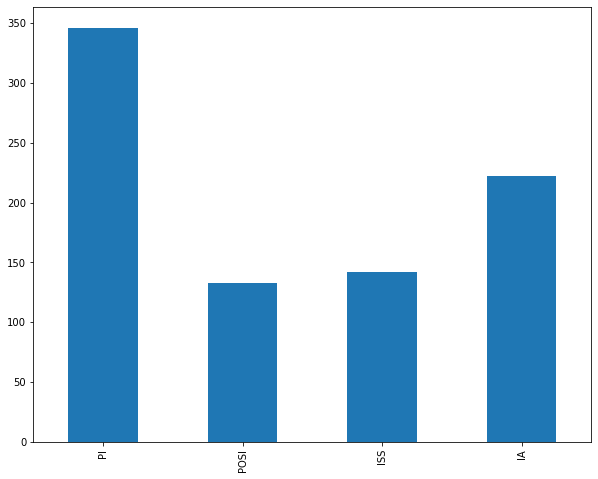

In [62]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

result_labels.sum(axis=0).plot.bar()

# Creating Multi-label Text Classification Models

There are two ways to create multi-label classification models: Using single dense output layer and using multiple dense output layers.

Multi-label text classification model with single output layer
In the first approach, we can use a single dense layer with 4 outputs with a sigmoid activation functions and binary cross entropy loss functions. Each neuron in the output dense layer will represent one of the 4 output labels. The sigmoid activation function will return a value between 0 and 1 for each neuron. If any neuron's output value is greater than 0.5, it is assumed that the comment belongs to the class represented by that particular neuron.

In [63]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [64]:
X = []
sentences = list(result["SA3"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = result_labels.values

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [66]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [67]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/Users/nehakardam/Documents/UWclasses /EE517 NLP/Lab 1/glove.6B.50d.txt', encoding="utf8")


for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

The following script creates the model. Our model will have one input layer, one embedding layer, one LSTM layer with 128 neurons and one output layer with 4 neurons since we have 4 labels in the output.

In [68]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(4, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [69]:
print(model.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 200)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 200, 50)           72100     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               91648     
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 516       
Total params: 164,264
Trainable params: 92,164
Non-trainable params: 72,100
_________________________________________________________________
None


In [70]:
# !pip install pydot

In [71]:
# !install graphviz

usage: install [-bCcpSsv] [-B suffix] [-f flags] [-g group] [-m mode]
               [-o owner] file1 file2
       install [-bCcpSsv] [-B suffix] [-f flags] [-g group] [-m mode]
               [-o owner] file1 ... fileN directory
       install -d [-v] [-g group] [-m mode] [-o owner] directory ...


In [72]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [75]:
# from keras.utils import plot_model
# from graphviz import Digraph
# plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

We will train our model for 5 epochs.

In [90]:
history = model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
4/4 [==============================] - 1s 147ms/step - loss: 0.5674 - acc: 0.5033 - val_loss: 0.5980 - val_acc: 0.4298
Epoch 2/6
4/4 [==============================] - 1s 140ms/step - loss: 0.5673 - acc: 0.5033 - val_loss: 0.5989 - val_acc: 0.4298
Epoch 3/6
4/4 [==============================] - 1s 140ms/step - loss: 0.5673 - acc: 0.5033 - val_loss: 0.5976 - val_acc: 0.4298
Epoch 4/6
4/4 [==============================] - 1s 142ms/step - loss: 0.5673 - acc: 0.5033 - val_loss: 0.5960 - val_acc: 0.4298
Epoch 5/6
4/4 [==============================] - 1s 139ms/step - loss: 0.5673 - acc: 0.5033 - val_loss: 0.5968 - val_acc: 0.4298
Epoch 6/6
4/4 [==============================] - 1s 140ms/step - loss: 0.5673 - acc: 0.5033 - val_loss: 0.5970 - val_acc: 0.4298


In [94]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

5/5 [==============================] - 0s 21ms/step - loss: 0.5771 - acc: 0.4755
Test Score: 0.5770677924156189
Test Accuracy: 0.4755244851112366


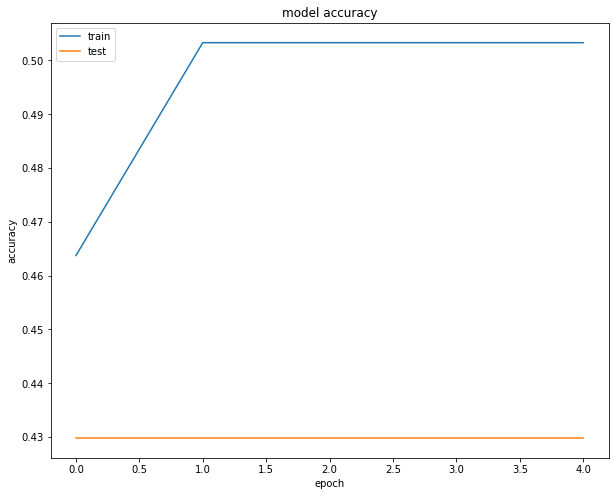

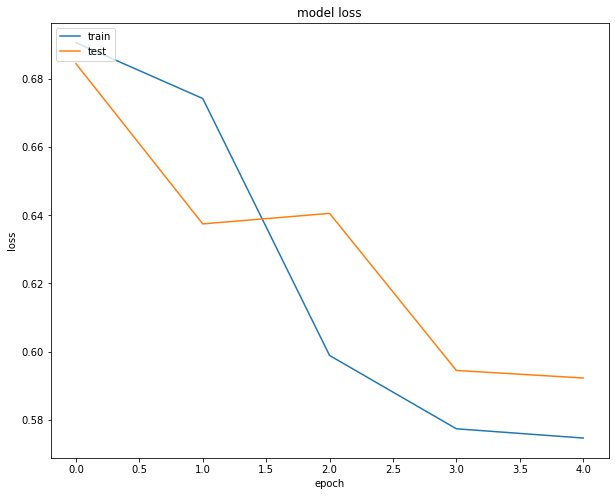

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

# Multi-lable Text Classification Model with Multiple Output Layers

In the second approach we will create one dense output layer for each label. We will have a total of 4 dense layers in the output. Each layer will have its own sigmoid function.

In [28]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [29]:
X = []
sentences = list(result["SA3"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = result[['PI', 'POSI', 'ISS', 'IA']]

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [31]:
# First output
y1_train = y_train[["PI"]].values
y1_test =  y_test[["PI"]].values

# Second output
y2_train = y_train[["POSI"]].values
y2_test =  y_test[["POSI"]].values

# Third output
y3_train = y_train[["ISS"]].values
y3_test =  y_test[["ISS"]].values

# Fourth output
y4_train = y_train[["IA"]].values
y4_test =  y_test[["IA"]].values



In [32]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [33]:
glove_file = open("/Users/nehakardam/Documents/UWclasses /EE517 NLP/Lab 1/glove.6B.50d.txt", encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [34]:
input_1 = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer1 = LSTM(128)(embedding_layer)

output1 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output2 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output3 = Dense(1, activation='sigmoid')(LSTM_Layer1)
output4 = Dense(1, activation='sigmoid')(LSTM_Layer1)

model = Model(inputs=input_1, outputs=[output1, output2, output3, output4])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [35]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 50)      72100       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 128)          91648       embedding_1[0][0]                
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1)            129         lstm_1[0][0]                     
____________________________________________________________________________________________

In [36]:
# from keras.utils import plot_model
# plot_model(model, to_file='model_plot4b.png', show_shapes=True, show_layer_names=True)

In [37]:
history = model.fit(x=X_train, y=[y1_train, y2_train, y3_train, y4_train], batch_size=8192, epochs=5, verbose=1, validation_split=0.2)

Epoch 1/5
1/1 [==============================] - 3s 3s/step - loss: 2.7726 - dense_1_loss: 0.6931 - dense_2_loss: 0.6931 - dense_3_loss: 0.6931 - dense_4_loss: 0.6931 - dense_1_acc: 0.4967 - dense_2_acc: 0.8176 - dense_3_acc: 0.8110 - dense_4_acc: 0.6945 - val_loss: 2.7660 - val_dense_1_loss: 0.6932 - val_dense_2_loss: 0.6898 - val_dense_3_loss: 0.6905 - val_dense_4_loss: 0.6926 - val_dense_1_acc: 0.4298 - val_dense_2_acc: 0.8246 - val_dense_3_acc: 0.7456 - val_dense_4_acc: 0.6491
Epoch 2/5
1/1 [==============================] - 0s 481ms/step - loss: 2.7651 - dense_1_loss: 0.6931 - dense_2_loss: 0.6898 - dense_3_loss: 0.6898 - dense_4_loss: 0.6924 - dense_1_acc: 0.5033 - dense_2_acc: 0.8220 - dense_3_acc: 0.8066 - dense_4_acc: 0.6945 - val_loss: 2.7580 - val_dense_1_loss: 0.6933 - val_dense_2_loss: 0.6856 - val_dense_3_loss: 0.6872 - val_dense_4_loss: 0.6919 - val_dense_1_acc: 0.4298 - val_dense_2_acc: 0.8246 - val_dense_3_acc: 0.7456 - val_dense_4_acc: 0.6491
Epoch 3/5
1/1 [==========

In [38]:
score = model.evaluate(x=X_test, y=[y1_test, y2_test, y3_test, y4_test], verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

5/5 [==============================] - 0s 22ms/step - loss: 2.7087 - dense_1_loss: 0.6933 - dense_2_loss: 0.6684 - dense_3_loss: 0.6610 - dense_4_loss: 0.6861 - dense_1_acc: 0.4755 - dense_2_acc: 0.7762 - dense_3_acc: 0.8252 - dense_4_acc: 0.6993
Test Score: 2.708740711212158
Test Accuracy: 0.693268895149231


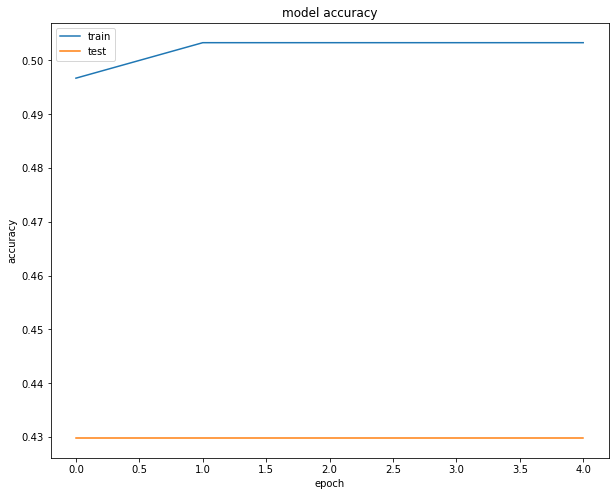

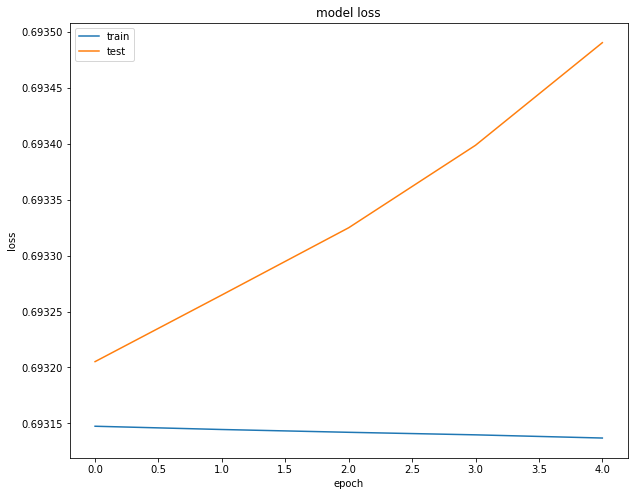

In [39]:
import matplotlib.pyplot as plt

plt.plot(history.history['dense_1_acc'])
plt.plot(history.history['val_dense_1_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['dense_1_loss'])
plt.plot(history.history['val_dense_1_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

https://stackabuse.com/python-for-nlp-multi-label-text-classification-with-keras/